# Project: RoadNX QC

For project specs:
- return the following information in the map_builder function:
    - geojson of each path generated
    - distance computed
    - time computed
    - all relevant features of associated fire station

In [4]:
import psycopg2
import networkx as nx
import osmnx as osx
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point,Polygon,LineString
import matplotlib.pyplot as plt
import folium
import json
import pickle
import numpy as np

In [5]:
conn = psycopg2.connect(dbname="eamgo", 
                 user="eamgo", 
                 password="shir0Kitsune8", 
                 host="127.0.0.1", 
                 port=5432)

# Extract Geometry of Building

In [3]:
# q = """
#     --select * 
#     --from pg_tables
#     --where schemaname = 'public'
#     select amenity, name, area, ref, other_tags,wkb_geometry
#     from public.multipolygons
#     --limit 10
#     """

# gpd.read_postgis(q, con=conn, geom_col='wkb_geometry')

## Extract Geometry of City

In [6]:
q = """
    SELECT name_2, geom
    FROM gadm.ph
    WHERE name_2 = 'Quezon City'
    """

poly = gpd.read_postgis(q, conn, geom_col='geom')
makati = poly.loc[0][1]

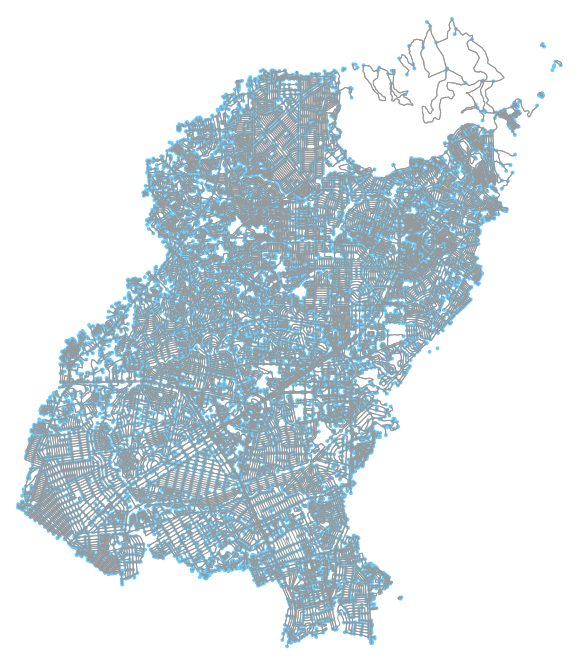

In [7]:
graph = osx.graph_from_polygon(makati, network_type='all_private',
                              retain_all=True)
plot = osx.plot_graph(graph, fig_height=12)

In [8]:
graph = osx.project_graph(graph, to_crs={'init': 'epsg:32651'})

In [7]:
# osx.save_graphml(graph, filename='QC_graph.graphml', gephi=True)

In [8]:
# graph = osx.load_graphml('QC_graph.graphml')

In [9]:
# with open('graph_qc2.pkl', 'wb') as f:
#     pickle.dump(graph, f)

## Get fire station coordinates

In [10]:
# pd.read_csv('qc_coords_caps.csv')

In [11]:
# q = """
#     with city as (
#     SELECT name_2 as x1, geom as dx
#     FROM gadm.ph
#     WHERE name_2 = 'Quezon City')
    
#     SELECT amenity, x1, name, wkb_geometry as dy
#     FROM points
#     JOIN city
#     ON st_within(wkb_geometry,dx)
#     WHERE amenity = 'fire_station'
#     AND name IS NOT NULL
#     """

# fs = gpd.read_postgis(q, conn, geom_col='dy')
# points = fs.drop_duplicates().drop('amenity', axis=1)

In [12]:
# import random
# caps = [1000,1500,1250]
# random.choice(caps)

1500

In [13]:
# points['truck_count'] = [np.random.randint(1, 5) for x in range(15)]
# points['GPM'] = [175 for x in range(15)]
# points['power'] = points['truck_count'] * points['GPM']
# points['capacity'] = [random.choice(caps) for x in range(15)]
# points['capacity_all'] = points['truck_count'] * points['capacity']

In [13]:
# points['limit'] = round(points['capacity_all']/points['power'])
# points

# Functions

In [9]:
def shortest_distance(graph, o_c, dest_c):
    """
    Creates a GeoDataFrame containing the edges of the shortest path
    from an origin to a destination point. These edges are represented 
    as linestrings that can be plotted on a map (folium works)
    
    Also prints the distance of the computed path.
    
    Parameters
    ----------
    graph : Graph 
        osmnx graph of the area containing the points
        
    o_c : tuple of floats
        coordinates of origin point in Long/Lat format
        
    dest_c : tuple of floats
        coordinates of destination point in Long/Lat format
        
    Returns
    -------
    path_gdf : GeoDataFrame
    
    shortest_dist : float
    """
    
    # Create a gdf to convert the geometry to standard crs
    
    try:
        gdf = gpd.GeoDataFrame([{"geometry": Point(o_c)},
                                {"geometry": Point(dest_c)}], 
                               crs={'init':'epsg:4326'})
        gdf.to_crs({'init': 'epsg:32651'}, inplace=True)
        origin_point = gdf.loc[0].geometry
        dest_point = gdf.loc[1].geometry
        
        # find the nearest node to the input points
        O = osx.get_nearest_node(graph, (origin_point.y, origin_point.x), 
                                 method='euclidean', return_dist=True)
        D = osx.get_nearest_node(graph, (dest_point.y, dest_point.x), 
                                 method='euclidean', return_dist=True)

        """
        create a dictionary of edges and their associated features
        note you can inspect the features by printing node_dict to see
        other available features""
        """   
        path = nx.shortest_path(graph, source=O[0], target=D[0])
        path_edges = []
        adj = graph.adj
        for i in range(0,len(path)-1):
            edges = adj[path[i]][path[i+1]]
            min_length = float("inf")
            min_edge = None
            for key in edges: 
                edge = edges[key]
                if edge["length"] < min_length:
                    min_length = edge["length"]
                    min_edge = edge
            path_edges.append((path[i],path[i+1],min_edge))
        node_dict = dict(graph.nodes)

        """
        generate a geodataframe to make it folium-ready
        """   
        gdf_builder = [] 
        for edge in path_edges:
            u = node_dict[edge[0]]
            v = node_dict[edge[1]]
            curr = edge[2] 
            if "geometry" not in curr: 
                geom = LineString([(u['x'],u['y']),(v['x'],v['y'])])
            else:
                geom = curr['geometry']
            res = {"source": edge[0], "target": edge[1], 
               "distance": edge[2]['length'],"geometry":geom}
            gdf_builder.append(res)
        path_gdf = gpd.GeoDataFrame(gdf_builder,crs={'init':'epsg:32651'})
        path_gdf.to_crs({'init':'epsg:4326'},inplace=True)
        path_gdf

        shortest_dist = path_gdf['distance'].sum()
    #     print('distance:', shortest_dist)

        # compute shortest path
    #     best_path = nx.shortest_path_length(graph, Point(o_c), Point(dest_c))   
        return path_gdf, shortest_dist
    except:
        print('Please choose a point closer to the road.')

In [10]:
def compute_time(speed, distance, return_minutes=True):
    """
    Parameters
    ----------
    speed : int
        speed in km/h
    distance : float
        distance in m
    """
    ms_speed = speed/3.6
    seconds = distance/ms_speed
    mins = seconds/60
    hours = mins/60
    if return_minutes:
        return round(mins, 2)
    else:
        return round(hours, 2)

In [11]:
def simulate_fire(graph, loc, dest, F_gdfs, geom_col, n):
    """
    NOTE: keep all inputs in lat/long format. 
    
    Parameters
    ----------
    loc : tuple
        center from where to make the map
        
    dest : tuple
        destination of all pts
        
    F_gdfs : GeoDataFrame
        all origin points, in LongLat format
    """
    curr_map = folium.Map(location = loc, zoom_start=n)
    
    folium.Marker(
            location=dest,
            popup='Destination',
            icon=folium.Icon(color='red')
            ).add_to(curr_map)
    
#     gdfs = []
    dists = []
    counter = 0
    
    for index,row in F_gdfs.iterrows():
        
        F = (row[geom_col].x, row[geom_col].y)
        try:
            gdf, dist = shortest_distance(graph, F, dest[::-1])
            dists.append(dist)
            
            geo_json = gdf.to_json()
            
            if compute_time(30, dist) <= 30:
            
                path = folium.features.GeoJson(geo_json)
                path.add_to(curr_map)

                folium.Marker(
                    location=F[::-1],
                popup=row['name']).add_to(curr_map)
                
                counter += 1
            else:
                print(row['name'], 'was too far.')
#             print('added to map')
        except:
            print('location outside graph')
            
    
#     folium.Marker(location=(14.610002, 121.076736),
#                  icon=folium.Icon(color='green')).add_to(curr_map)
# #             print('added to map')
    print('Number of fire stations deployed:', counter)
    return curr_map

In [12]:
def return_features(graph, dest, F_gdfs, geom_col):
    """
    NOTE: keep all inputs in lat/long format. 
    
    Parameters
    ----------
    dest : tuple
        destination of all pts
        
    F_gdfs : GeoDataFrame
        all origin points
    """
    gdfs = {}
    name_dists = []
    name = []
    distance_ = []
    time_ = []
    index_ = []
    counter = 0
    
    for index,row in F_gdfs.iterrows():
        
        F = (row[geom_col].x, row[geom_col].y)
        try:  
            gdf, dist = shortest_distance(graph, F, dest[::-1])

            if compute_time(30, dist) <= 30:
                name_dists.append((row['name'], round(dist, 2), compute_time(30, dist)))
                name.append(row['name'])
                distance_.append(round(dist, 2))
                time_.append(compute_time(30, dist))
                gdfs[counter] = json.loads(gdf.to_json())
                index_.append(counter)
                counter += 1
            
            else:
                print(row['name'], 'was too far.')

        except:
            print('location outside graph')
            
    out = pd.DataFrame({'id': index_, 'name': name, 'distance': distance_, 'time': time_})
    
    return gdfs, out.sort_values(by='time')
#     return gdfs, name_dists, counter

In [13]:
def increase_fire(HP, rate):
    HP = HP * (1+rate)
    return HP

In [14]:
def simulate_trucks(HP, df_sim, debug=True):
    """
    Simulates the sequenced arrival of all trucks.
    """
#     display(df_sim)
    # increases every step. Tracks minutes
    timer = 0

    # roller increases to index through time_steps
    # will increase only if condition is fulfilled
    roller = 0

    # power is initalized as a list and summed later on
    # we take each fire station's group of trucks as a single entity
    power = []
    limiter = np.array([])
    
    # place here all stations deployed
    stations = pd.DataFrame()

    # generate a list of all unique values in time
    time_steps = list(set(df_sim['time_round'].tolist()))

    while HP > 0:
        if debug:
            print("minutes elapsed:", timer)

        # will perform this action if there are still fire trucks that have 
        # not arrived
        try:
            if timer == time_steps[roller]:
                if debug:
                    print(timer)

                sliced = df_sim[df_sim['time_round']==time_steps[roller]]
                # creates a sliced dataframe so we can iterate through all values
                # needed in the df
                if debug:
                    display(sliced)
                stations = pd.concat((stations, sliced))
                

                power_add = []

                for index,row in sliced.iterrows():
                    """
                    PLEASE ADD SOMETHING TO MODIFY THE POWER VALUE
                    """
                    power_add.append(row['power'])
                    limiter = np.append(limiter, int(row['limit']))
                if debug:
                    print("power added:", sum(power_add))
                power.extend(power_add)
                
                # These track indexes from limiter to check
                # if it still has water in the tank
                if len(np.where(limiter==0)[0]) == 0:
                    if debug:
                        print("keep subtracting")
                else:
                    if debug:
                        print("something has reached 0")
                    indexes = list(np.where(limiter==0)[0])
                    if debug:
                        print(indexes)
                    replacements = [0 for i in range(len(indexes))]
                    if debug:
                        print(replacements)

                    for (index, replacement) in zip(indexes, replacements):
                        power[index] = replacement
                if debug:
                    print(limiter)

                # time passes

                limiter = limiter - 1
                roller += 1
                timer += 1
#                 if stations.empty:
#                     HP = increase_fire(HP, 0.02)
#                     if debug:
#                         print('fire grows')
            else:
                timer +=1
#                 if stations.empty:
#                     HP = increase_fire(HP, 0.02)
#                     if debug:
#                         print('fire grows')

        # when all fire trucks arrive, they need to exhaust all capacities
        except:
            print("All fire trucks have arrived")

            if len(np.where(limiter==0)[0]) == 0:
                    print("keep subtracting")
            else:
                print("something has reached 0")
                indexes = list(np.where(limiter==0)[0])
                print(indexes)
                replacements = [0 for i in range(len(indexes))]
                print(replacements)

                for (index, replacement) in zip(indexes, replacements):
                    power[index] = replacement

            if power == [0 for x in range(len(power))]:
                print('failed to extinguish fire :--(')
                break

            limiter = limiter - 1
            timer += 1
        if debug:
            print('current power:', power)
        HP -= sum(power)
        if debug:
            print('remaining HP:', HP)
            
    if debug:
        print("number of stations deployed:", len(stations))
        print(timer, "minutes to extinguish fire")
    
    return len(stations), timer, FS_df.merge(stations)

# Fire HP Estimation

In [58]:
with open('fire_spread_res2.pkl', 'rb') as p:
     fire_rate = pickle.load(p)

In [59]:
fire_rate

{0: [(<shapely.geometry.point.Point at 0x7f18c089b590>,
   0    POLYGON ((290085.387 1619962.070, 290085.339 1...
   dtype: geometry,
   10.0)],
 1: [(<shapely.geometry.point.Point at 0x7f18c089b590>,
   0    POLYGON ((290086.100 1619962.070, 290086.049 1...
   dtype: geometry,
   10.713333333333333)],
 2: [(<shapely.geometry.point.Point at 0x7f18c089b590>,
   0    POLYGON ((290086.813 1619962.070, 290086.758 1...
   dtype: geometry,
   11.426666666666666)],
 3: [(<shapely.geometry.point.Point at 0x7f18c089b590>,
   0    POLYGON ((290087.527 1619962.070, 290087.468 1...
   dtype: geometry,
   12.14)],
 4: [(<shapely.geometry.point.Point at 0x7f18c089b590>,
   0    POLYGON ((290088.240 1619962.070, 290088.178 1...
   dtype: geometry,
   12.853333333333333)],
 5: [(<shapely.geometry.point.Point at 0x7f18c089b590>,
   0    POLYGON ((290088.953 1619962.070, 290088.888 1...
   dtype: geometry,
   13.566666666666666)],
 6: [(<shapely.geometry.point.Point at 0x7f18c089b590>,
   0    POLYGON (

# Fire Simulation

`fire` initializes the coordinates of the fire location as a tuple. 

In [15]:
fire = 14.654950, 121.070882

In [18]:
with open('data/qc_coords_gdf.pkl', 'rb') as f:
    FS_df = pickle.load(f)

`return_features` will return the geojsons of all paths, and a dataframe containing the `time` column, which is important to the simulation.

In [19]:
paths_gdfs, df = return_features(graph, fire, FS_df, geom_col='dy')

Please choose a point closer to the road.
location outside graph


In [50]:
# return_features_debug(graph, fire, points, geom_col='dy')

In [20]:
df_sim = df.merge(FS_df)
df_sim['time_round'] = df_sim['time'].apply(lambda x: round(x))

In [21]:
df_sim

,id,name,distance,time,capacity_all,power,dy,limit,time_round
0,8,MARILAG FIRE SUBSTATION,2605.21,5.21,1000.0,175.0,POINT (121.05802 14.65134),6,5
1,0,AGHAM FIRE SUBSTATION,5041.41,10.08,3000.0,350.0,POINT (121.03851 14.65192),9,10
2,14,PROJECT 6 FIRE SUBSTATION,5363.95,10.73,2000.0,350.0,POINT (121.04071 14.66227),6,11
3,10,NEW ERA FIRE SUBSTATION,5491.63,10.98,1000.0,175.0,POINT (121.06072 14.66712),6,11
4,15,QUIRINO 2A FIRE SUBSTATION,6061.87,12.12,1000.0,175.0,POINT (121.05912 14.63139),6,12
5,13,PINAGKAISAHAN FIRE SUBSTATION,6340.49,12.68,1000.0,175.0,POINT (121.04639 14.62798),6,13
6,3,CONGRESS FIRE SUBSTATION,6732.90,13.47,1750.0,350.0,POINT (121.09440 14.69376),5,13
7,5,FRISCO FIRE SUBSTATION,8218.20,16.44,500.0,175.0,POINT (121.01879 14.65477),3,16
8,16,RAMON MAGSAYSAY FIRE SUBSTATION,8492.81,16.99,200.0,175.0,POINT (121.02155 14.65944),1,17
9,2,BAHAY TORO FIRE SUBSTATION,8590.36,17.18,500.0,175.0,POINT (121.02119 14.66690),3,17


## Fire Truck Action Simulator

In [54]:
stations_deployed, time_elapsed, fire_stations = simulate_trucks(7000, df_sim, debug=True)

minutes elapsed: 0
fire grows
current power: []
remaining HP: 7140.0
minutes elapsed: 1
fire grows
current power: []
remaining HP: 7282.8
minutes elapsed: 2
fire grows
current power: []
remaining HP: 7428.456
minutes elapsed: 3
fire grows
current power: []
remaining HP: 7577.02512
minutes elapsed: 4
fire grows
current power: []
remaining HP: 7728.5656224
minutes elapsed: 5
5


,id,name,distance,time,capacity_all,power,dy,limit,time_round
0,8,MARILAG FIRE SUBSTATION,2605.21,5.21,1000.0,175.0,POINT (121.05802 14.65134),6,5


power added: 175.0
keep subtracting
[6.]
current power: [175.0]
remaining HP: 7553.5656224
minutes elapsed: 6
current power: [175.0]
remaining HP: 7378.5656224
minutes elapsed: 7
current power: [175.0]
remaining HP: 7203.5656224
minutes elapsed: 8
current power: [175.0]
remaining HP: 7028.5656224
minutes elapsed: 9
current power: [175.0]
remaining HP: 6853.5656224
minutes elapsed: 10
10


,id,name,distance,time,capacity_all,power,dy,limit,time_round
1,0,AGHAM FIRE SUBSTATION,5041.41,10.08,3000.0,350.0,POINT (121.03851 14.65192),9,10


power added: 350.0
keep subtracting
[5. 9.]
current power: [175.0, 350.0]
remaining HP: 6328.5656224
minutes elapsed: 11
11


,id,name,distance,time,capacity_all,power,dy,limit,time_round
2,14,PROJECT 6 FIRE SUBSTATION,5363.95,10.73,2000.0,350.0,POINT (121.04071 14.66227),6,11
3,10,NEW ERA FIRE SUBSTATION,5491.63,10.98,1000.0,175.0,POINT (121.06072 14.66712),6,11


power added: 525.0
keep subtracting
[4. 8. 6. 6.]
current power: [175.0, 350.0, 350.0, 175.0]
remaining HP: 5278.5656224
minutes elapsed: 12
12


,id,name,distance,time,capacity_all,power,dy,limit,time_round
4,15,QUIRINO 2A FIRE SUBSTATION,6061.87,12.12,1000.0,175.0,POINT (121.05912 14.63139),6,12


power added: 175.0
keep subtracting
[3. 7. 5. 5. 6.]
current power: [175.0, 350.0, 350.0, 175.0, 175.0]
remaining HP: 4053.5656224000004
minutes elapsed: 13
13


,id,name,distance,time,capacity_all,power,dy,limit,time_round
5,13,PINAGKAISAHAN FIRE SUBSTATION,6340.49,12.68,1000.0,175.0,POINT (121.04639 14.62798),6,13
6,3,CONGRESS FIRE SUBSTATION,6732.90,13.47,1750.0,350.0,POINT (121.09440 14.69376),5,13


power added: 525.0
keep subtracting
[2. 6. 4. 4. 5. 6. 5.]
current power: [175.0, 350.0, 350.0, 175.0, 175.0, 175.0, 350.0]
remaining HP: 2303.5656224000004
minutes elapsed: 14
current power: [175.0, 350.0, 350.0, 175.0, 175.0, 175.0, 350.0]
remaining HP: 553.5656224000004
minutes elapsed: 15
current power: [175.0, 350.0, 350.0, 175.0, 175.0, 175.0, 350.0]
remaining HP: -1196.4343775999996
number of stations deployed: 7
16 minutes to extinguish fire


In [55]:
fire_stations

,name,capacity_all,power,dy,limit,id,distance,time,time_round
0,AGHAM FIRE SUBSTATION,3000.0,350.0,POINT (121.03851 14.65192),9,0,5041.41,10.08,10
1,CONGRESS FIRE SUBSTATION,1750.0,350.0,POINT (121.09440 14.69376),5,3,6732.90,13.47,13
2,MARILAG FIRE SUBSTATION,1000.0,175.0,POINT (121.05802 14.65134),6,8,2605.21,5.21,5
3,NEW ERA FIRE SUBSTATION,1000.0,175.0,POINT (121.06072 14.66712),6,10,5491.63,10.98,11
4,PINAGKAISAHAN FIRE SUBSTATION,1000.0,175.0,POINT (121.04639 14.62798),6,13,6340.49,12.68,13
5,PROJECT 6 FIRE SUBSTATION,2000.0,350.0,POINT (121.04071 14.66227),6,14,5363.95,10.73,11
6,QUIRINO 2A FIRE SUBSTATION,1000.0,175.0,POINT (121.05912 14.63139),6,15,6061.87,12.12,12


In [188]:
time_elapsed

16

In [189]:
stations_deployed

4

In [190]:
# df.to_csv('test_stations.csv')

In [56]:
# filt = points.merge(fire_stations)
to_front_gdf, dummy_df = return_features(graph, fire, fire_stations, geom_col='dy')

In [57]:
fire_map = simulate_fire(graph, fire, fire, fire_stations, geom_col='dy', n=13)
fire_map

Number of fire stations deployed: 7
